<a href="https://colab.research.google.com/github/Shashi3k/Anomaly-Detection-In-Financial-Transaction/blob/main/Anomaly_Detection_in_Financial_Transaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snb

import warnings
warnings.filterwarnings('ignore')

In [3]:
#read the dataset
df = pd.read_csv('transaction_dataset.csv')

In [5]:
#check the shape
df.shape

(9841, 51)

In [6]:
#check the data types
df.dtypes

Unnamed: 0                                                int64
Index                                                     int64
Address                                                  object
FLAG                                                      int64
Avg min between sent tnx                                float64
Avg min between received tnx                            float64
Time Diff between first and last (Mins)                 float64
Sent tnx                                                  int64
Received Tnx                                              int64
Number of Created Contracts                               int64
Unique Received From Addresses                            int64
Unique Sent To Addresses                                  int64
min value received                                      float64
max value received                                      float64
avg val received                                        float64
min val sent                            

In [8]:
df.columns = df.columns.str.strip().str.replace(r'\b\s+\b','_',regex=True)
df.columns

Index(['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg_min_between_sent_tnx',
       'Avg_min_between_received_tnx',
       'Time_Diff_between_first_and_last (Mins)', 'Sent_tnx', 'Received_Tnx',
       'Number_of_Created_Contracts', 'Unique_Received_From_Addresses',
       'Unique_Sent_To_Addresses', 'min_value_received', 'max_value_received',
       'avg_val_received', 'min_val_sent', 'max_val_sent', 'avg_val_sent',
       'min_value_sent_to_contract', 'max_val_sent_to_contract',
       'avg_value_sent_to_contract',
       'total_transactions (including_tnx_to_create_contract',
       'total_Ether_sent', 'total_ether_received',
       'total_ether_sent_contracts', 'total_ether_balance', 'Total_ERC20_tnxs',
       'ERC20_total_Ether_received', 'ERC20_total_ether_sent',
       'ERC20_total_Ether_sent_contract', 'ERC20_uniq_sent_addr',
       'ERC20_uniq_rec_addr', 'ERC20_uniq_sent_addr.1',
       'ERC20_uniq_rec_contract_addr', 'ERC20_avg_time_between_sent_tnx',
       'ERC20_avg_time_be

In [9]:
#Check for presence of duplicates in the entire dataset
df.duplicated(subset='Index').sum()

5112

In [10]:
#Check the Proportion of flag in the overall dataset
df['FLAG'].value_counts(normalize=True)

0    0.778579
1    0.221421
Name: FLAG, dtype: float64

In [12]:
#Check the proportion of flag in the duplicated rows
df[df.duplicated(subset = 'Index')]['FLAG'].value_counts(normalize=True)

0    0.573748
1    0.426252
Name: FLAG, dtype: float64

In [13]:
#Check duplicates without Index column
df.duplicated().sum()

0

In [15]:
#drop the unwanted columns that doesn't provide any significance to the anomaly detection
df=df.drop(columns=['Unnamed: 0','Index','Address'])

In [16]:
#seperate the categorical variables since isolation forest doesn't understand the object datatypes
categories = df.select_dtypes(include = 'object').columns

In [17]:
#Inspect the categories
for i in df[categories].columns:
  print(f'The column {i} has {df[i].nunique()} unique values and {df[i].isnull().sum()} missing values')

The column ERC20_most_sent_token_type has 305 unique values and 841 missing values
The column ERC20_most_rec_token_type has 467 unique values and 851 missing values


In [18]:
#seperate the numerical variables
numerics = df.select_dtypes(include = 'number').columns

In [20]:
#Inspect the featres with constant variance
constant_cols = df[numerics].var()[df[numerics].var() == 0].index
constant_cols

Index(['ERC20_avg_time_between_sent_tnx', 'ERC20_avg_time_between_rec_tnx',
       'ERC20_avg_time_between_rec_2_tnx',
       'ERC20_avg_time_between_contract_tnx', 'ERC20_min_val_sent_contract',
       'ERC20_max_val_sent_contract', 'ERC20_avg_val_sent_contract'],
      dtype='object')

In [22]:
#Drop the constant columns which are having constant variance as they do not contribute much while deciding whether the datapoint is an anomaly or not
df.drop(constant_cols, axis=1, inplace=True)

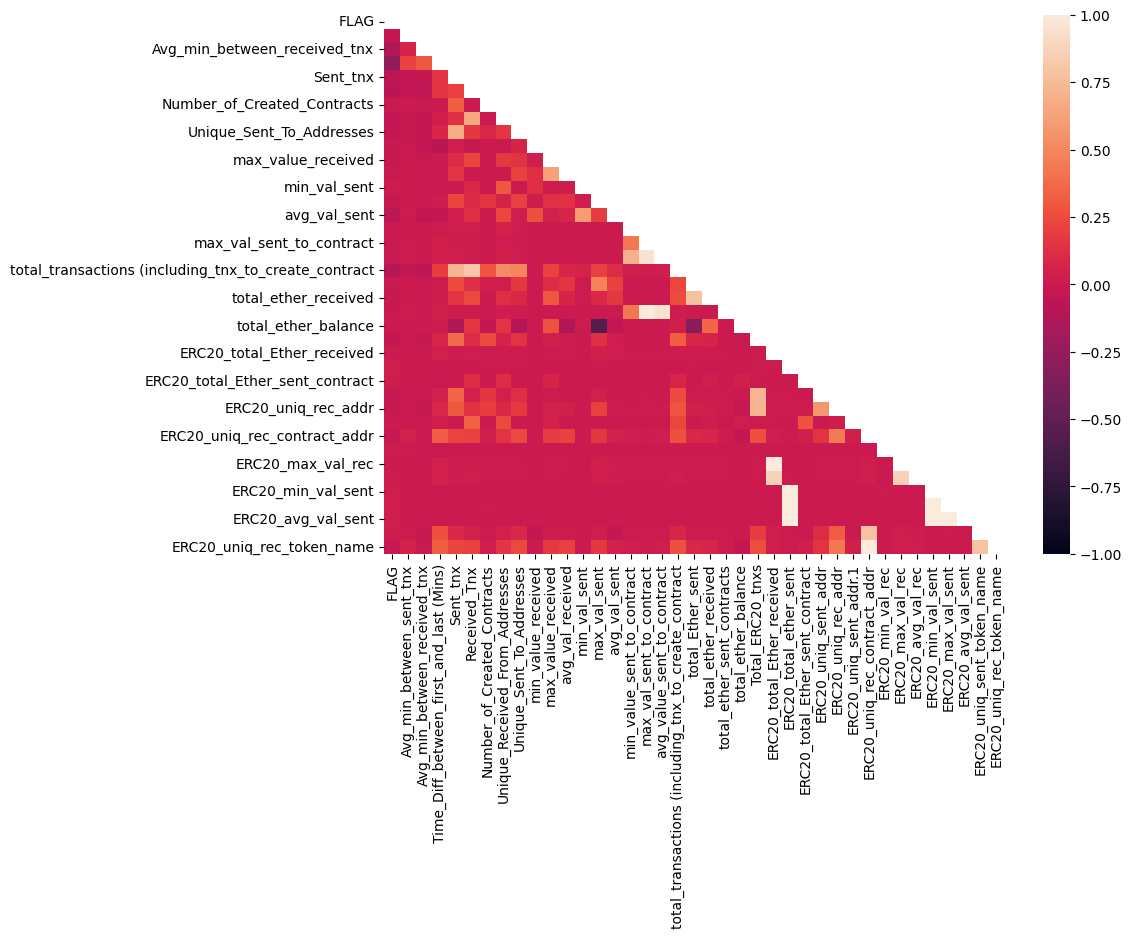

In [25]:
# Correlation matrix(fyi: this doesnot contribute anything in this scenario, but can be useful to people who want to check the correlation between two variables)
plt.figure(figsize = (10,7))
numerics = df.select_dtypes(include = 'number').columns
corr = df[numerics].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]= True
snb.heatmap(corr, mask=mask, annot=False, vmin=-1, vmax = 1)
plt.show()

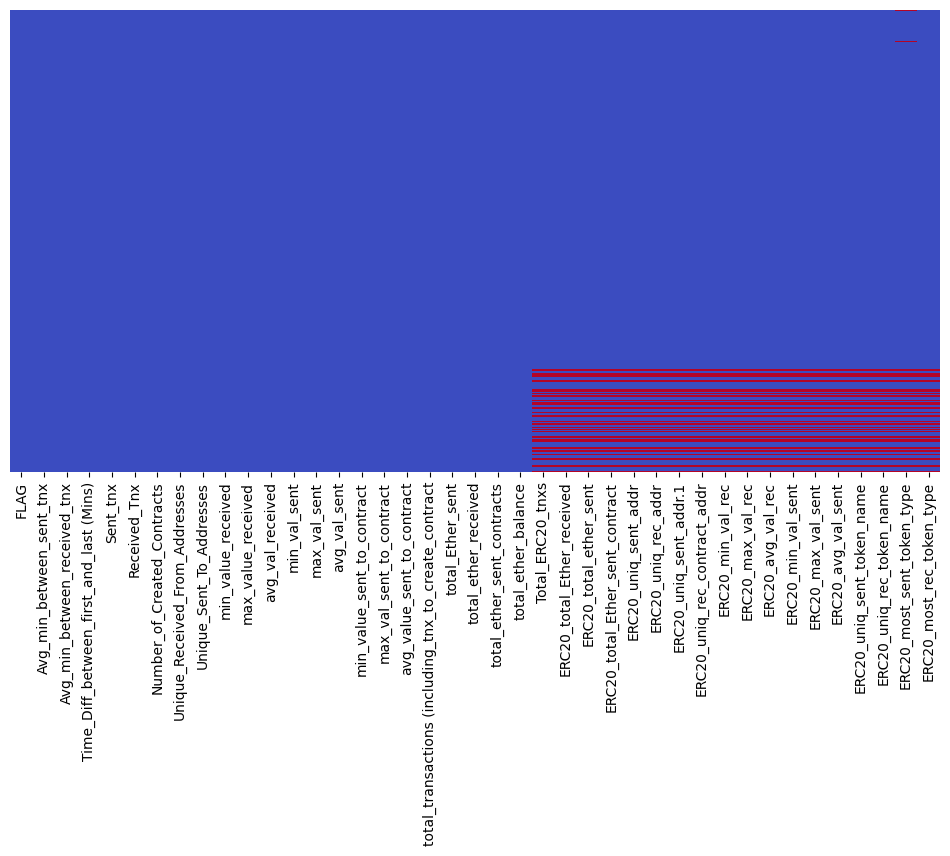

In [26]:
#Visualize missing pattern of the dataframe
plt.figure(figsize=(12,6))
snb.heatmap(df.isnull(),cmap='coolwarm',cbar = False)
plt.yticks([])
plt.show()

In [27]:
#Count rows with missing values
missing_rows_count = df.isnull().any(axis=1).sum()
print(f'The number of rows with atleast one missing value is {missing_rows_count}')

The number of rows with atleast one missing value is 860


In [28]:
#Investigate the FLAG variable for rows with missing data
missing_mask = df.isnull().any(axis=1)
print(df.loc[missing_mask, 'FLAG'].value_counts())
print(" ")
print(round(df.loc[missing_mask, 'FLAG'].value_counts(normalize = True), 2))

1    829
0     31
Name: FLAG, dtype: int64
 
1    0.96
0    0.04
Name: FLAG, dtype: float64


In [29]:
#Target distribution
print(df['FLAG'].value_counts())
print(" ")
print(round(df['FLAG'].value_counts(normalize=True), 2))

0    7662
1    2179
Name: FLAG, dtype: int64
 
0    0.78
1    0.22
Name: FLAG, dtype: float64


In [30]:
#Rows other than the ones with missing values
df_sub = df[~missing_mask]

In [31]:
#Split the data into training(80%) and testing (20%)
X= df_sub.drop('FLAG', axis=1)
y= df_sub['FLAG']
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, random_state=123)

In [32]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.0 MB/s eta 0:00:00


In [33]:
# Converting the categories into numeric type
from category_encoders import TargetEncoder
#Initializing the TargetEncoder
encoder = TargetEncoder(cols = categories)
#Fit and transform the train data
X_train_encoded = encoder.fit_transform(X_train, y_train)
#Transform the test data
X_test_encoded = encoder.transform(X_test)

In [34]:
#Concating X and y
train = pd.concat([X_train_encoded,y_train], axis=1)
test = pd.concat([X_test_encoded, y_test], axis=1)

In [36]:
from sklearn.ensemble import IsolationForest

#Create an Isolation Forest Model
isolation_forest = IsolationForest(contamination="auto", random_state=123)

#Train the model on the training set
isolation_forest.fit(train)

#Predict the outliers on the training and testing set
#-1 indicates outlier and 1 indicates not an outlier or normal
anomaly_train_pred = isolation_forest.predict(train)
anomaly_test_pred = isolation_forest.predict(test)

#Print the number of outlier in the training set
print(f'The Number of outlier in the training set are {np.sum(anomaly_train_pred==-1)}')
print(f'The Number of outlier in the testing set are {np.sum(anomaly_test_pred==-1)}')

The Number of outlier in the training set are 219
The Number of outlier in the testing set are 51


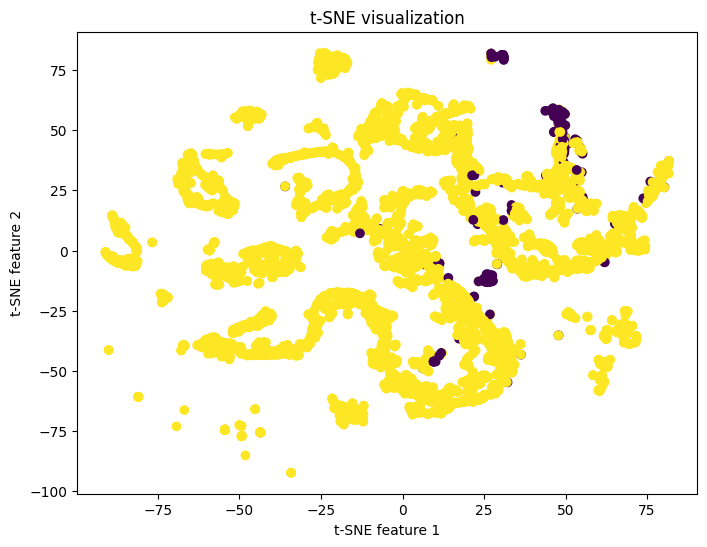

In [39]:
from sklearn.manifold import TSNE
#Create and fit TSNE transform
tsne = TSNE(n_components=2, random_state=123)
X_train_tsne = tsne.fit_transform(train)

#Visualizing the transformed data
plt.figure(figsize=(8,6))
plt.scatter(X_train_tsne[: ,0], X_train_tsne[:,1], c=anomaly_train_pred)
plt.title('t-SNE visualization')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()